#Configuration and imports

In [ ]:
!pip install flickrapi

from flickrapi import FlickrAPI
import urllib

from PIL import Image
from time import sleep
import random
import numpy as np
import pandas as pd
import os
from os import path
from io import BytesIO
import requests

from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow
import cv2

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 3.5 MB/s eta 0:00:00
Mounted at /content/drive


#Connecting to Flickr API

In [ ]:
#Create a file with your Flickr API key and secret number
#I put my into Flickr_secret module

import Flickr_secret

key = Flickr_secret.get_key()
secret = Flickr_secret.get_secret()

###List of sizes

* url_o: Original
* url_k: Large 2048 (2048 × 1463)
* url_h: Large 1600 (1600 × 1143)
* url_l=: Large 1024 (1024 × 732)
* url_c: Medium 800 (800 × 572)
* url_z: Medium 640 (640 × 457)
* url_m: Medium 500 (500 × 357)
* url_n: Small 320 (320 × 229)
* url_s: Small 240 (240 × 171)
* url_t: Thumbnail (100 × 71)
* url_q: Square 150 (150 × 150)
* url_sq: Square 75 (75 × 75)

#Obtaining data from flickr
##Defining handy functions to collect images

In first approach I tried to download smaller images first.
If there were not small ones, I took bigger ones.
However after few model runs, I changed my strategy, cause the results were not satisfying.
To go from bigger to smaller gave better results at the end.

In [ ]:
#Defining the list of sizes
#We chceck sizes from the first one in a list, if there no size of the image, we pick up next one in list
sizes = ["url_n", "url_m", "url_z", "url_c", "url_l", "url_o", "url_q"]

#Defining the size of dataset (images to download)
images_per_page = 1250

#receiving list of images "displayed" on a page
def get_images(keyword, sizes, images_per_page):
  '''
  Takes keyword as a string, sizes as a list of image sizes, images_per_page as integer
  Returns list of images sorted by relevance
  '''
  extras = ','.join(sizes)
  flickr = FlickrAPI(key, secret)
  images = flickr.walk(text=keyword,
                      tag_mode='all',
                      extras=extras,
                      per_page=images_per_page,
                      sort='relevance')
  return images


#getting url for single image
def get_url(image, sizes):
  '''
  Takes image and size as list,
  Returns url for inputed image of a selected size
  '''
  #picking up images of the size based on previously defined list
  try:
    for i in range(len(sizes)):
      url = image.get(sizes[i])
      if url:
        return url
  except:
    print("Cannot obtain url")


#getting list of urls of images with url for dataset
def get_urls(keyword, sizes, images_per_page):
  images = get_images(keyword, sizes, images_per_page)
  counter = 0
  urls=[] 

  for image in images:
    if counter < images_per_page:
      url = get_url(image, sizes)  # get preffered size url
      urls.append(url)
      counter += 1
    else:
      break

  return urls


#downloading images to Your google drive
def images_downloader(keyword, sizes, images_per_page, path):
  urls = get_urls(keyword, sizes, images_per_page)
  #changing the space for underscore to create a folder with 'continious' name
  keyword = keyword.replace(' ', '_')
  os.makedirs(f'{path}/{keyword}/train/{keyword}', exist_ok=True)

  for i, url in enumerate(urls):
    #download only '.jpg' as other formats may cause some issues at model training 
    if url[-4:] == '.jpg':
      try:
        response = requests.get(url)
        content = response.content
        img = Image.open(BytesIO(content))
        file_name = f'000{i}.jpg'
        img.save(f'{path}/{keyword}/train/{keyword}/{file_name}')
        if i % 20 == 0:
          print(f'Downloaded {i} images of {len(urls)}')      
      except:
        print(f"Coudn't download image number: {i} \nwith url: {url}")
  print("Finished")

##Downloading

In [ ]:
#create a folder for image dataset
data_path = 'drive/MyDrive/test'#'drive/MyDrive/SDA_Final'

#defining keywords for set of images, which will be downloaded
encoder_keyword = 'cat' #'skyscraper'
decoder_keyword = 'dog' #'watercolor buildings'

In [ ]:
images_downloader(encoder_keyword, sizes, images_per_page, data_path)

images_downloader(decoder_keyword, sizes, images_per_page, data_path)

#when downloading is finished, changing a keyword to match folder name
decoder_keyword = decoder_keyword.replace(' ', '_')

Downloaded 0 images of 1250
Downloaded 20 images of 1250
Downloaded 40 images of 1250
Downloaded 60 images of 1250
Downloaded 80 images of 1250
Downloaded 100 images of 1250
Downloaded 120 images of 1250
Downloaded 140 images of 1250
Downloaded 160 images of 1250
Downloaded 180 images of 1250
Downloaded 200 images of 1250
Downloaded 220 images of 1250
Downloaded 240 images of 1250
Downloaded 260 images of 1250
Downloaded 280 images of 1250
Downloaded 300 images of 1250
Downloaded 320 images of 1250
Downloaded 340 images of 1250
Downloaded 360 images of 1250
Downloaded 380 images of 1250
Downloaded 400 images of 1250
Downloaded 420 images of 1250
Downloaded 440 images of 1250
Downloaded 460 images of 1250
Downloaded 480 images of 1250
Downloaded 500 images of 1250
Downloaded 520 images of 1250
Downloaded 540 images of 1250
Downloaded 560 images of 1250
Downloaded 580 images of 1250
Downloaded 600 images of 1250
Downloaded 620 images of 1250
Downloaded 640 images of 1250
Downloaded 660 i

In [ ]:
#check of the train datasets volume
print(len(os.listdir(f'{data_path}/{decoder_keyword}/train/{decoder_keyword}')))
print(len(os.listdir(f'{data_path}/{encoder_keyword}/train/{encoder_keyword}')))

1250
1250


At this point the image dataset is created.
As images were downloaded from flickr in a big batch size, I suggest to go to folder and do "manual/visual" check of images. This to eliminate unrelevant, demaged or somehow cutted pictures with big part of black, white or empty pixels. The model shouldn't be trained on false dataset, which will have negative impact in result. 

In [ ]:
#dividing dataset into test / train collections
#test dataset to check our output on random picture which was never seen by model

test_size = 0.2

#as it is one-time action, there is only a for loop
for keyword in [f'{encoder_keyword}', f'{decoder_keyword}']:
  os.makedirs(data_path + '/' + keyword + '/test/' + keyword, exist_ok=True)
  file_list = os.listdir(data_path + '/' + keyword + '/train/' + keyword)
  number_of_samples = int(len(file_list) * test_size)
  for file_name in random.sample(file_list, number_of_samples):
    os.rename(data_path + '/' + keyword + '/train/' + keyword + '/' + file_name,
              data_path + '/' + keyword + '/test/' + keyword + '/' + file_name)
  #check of the test data volume
  print(len(os.listdir(f'{data_path}/{keyword}/test/{keyword}')))

10
10


#Model
##Definitions

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

In [ ]:
batch_size = 64
img_height = 232
img_width = 232
image_size = [img_height, img_width]
data_dir = '/content/' + data_path + '/' + encoder_keyword + '/train'

In [ ]:
#create dataset from directory
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed=12, #randomsate to have same data
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed=12, 
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1246 files belonging to 1 classes.
Using 997 files for training.
Found 1246 files belonging to 1 classes.
Using 249 files for validation.


##Preprocessing

In [ ]:
#Data augumentation to develop a training set

data_augmentation = Sequential(
    [layers.RandomFlip("horizontal"), 
     #layers.RandomRotation(0.1)
     ])

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE)

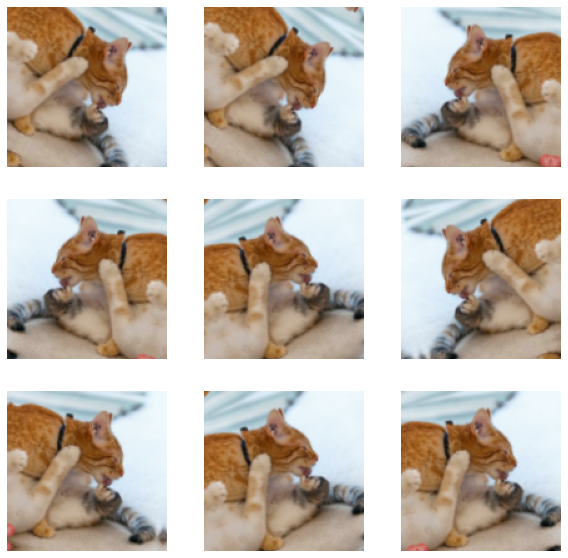

In [ ]:
#plotting some augumented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#Normalizing data
normalization_layer = tf.keras.layers.Rescaling(1./255)

def change_inputs(images, labels):
  '''
  This function takes images and labels from a dataset as an input.
  Returns x, and x instead of 'y' as in autoencoder image is compared to itself.
  Input and output should be the same or at least as close as possible.
  '''
  x = tf.image.resize(normalization_layer(images), [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return x, x

#changing data for training
normalized_ds = train_ds.map(change_inputs)
normalized_val_ds = val_ds.map(change_inputs)

normalized_ds = normalized_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)


# Prefetching samples in GPU memory helps maximize GPU utilization.
# May help in Jupyther notebook, didn't work in Colab well for me
#normalized_ds = normalized_ds.prefetch(tf.data.AUTOTUNE)
#normalized_val_ds = normalized_val_ds.prefetch(tf.data.AUTOTUNE)


##Model 1

In [ ]:
model = Sequential()
#Encoder layers
model.add(layers.Conv2D(32, (11, 11),
                        activation='relu',
                        input_shape=(img_width, img_height, 3),
                        padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(16, (9, 9), activation='relu', padding='same'))
model.add(layers.Conv2D(8, (9, 9), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(8, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

#Decoder layers
model.add(layers.Conv2D(8, (5, 5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

#Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 232, 232, 32)      11648     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 116, 116, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 116, 116, 16)      41488     
                                                                 
 conv2d_15 (Conv2D)          (None, 116, 116, 8)       10376     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 8)        0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 58, 58, 8)        

In [ ]:
#training a model
history = model.fit(
    normalized_ds, 
    validation_data = normalized_val_ds,
    epochs = 100,
    verbose = 1,
    batch_size = 92
)

Epoch 1/100
16/16 [==============================] - 143s 4s/step - loss: 0.6895 - acc: 0.5374 - val_loss: 0.6763 - val_acc: 0.7107
Epoch 2/100
16/16 [==============================] - 16s 897ms/step - loss: 0.6735 - acc: 0.6297 - val_loss: 0.6478 - val_acc: 0.5384
Epoch 3/100
16/16 [==============================] - 16s 887ms/step - loss: 0.6664 - acc: 0.5661 - val_loss: 0.6300 - val_acc: 0.7120
Epoch 4/100
16/16 [==============================] - 16s 907ms/step - loss: 0.6577 - acc: 0.6532 - val_loss: 0.6093 - val_acc: 0.7121
Epoch 5/100
16/16 [==============================] - 16s 840ms/step - loss: 0.6534 - acc: 0.6541 - val_loss: 0.5996 - val_acc: 0.7120
Epoch 6/100
16/16 [==============================] - 16s 854ms/step - loss: 0.6575 - acc: 0.6528 - val_loss: 0.6133 - val_acc: 0.7105
Epoch 7/100
16/16 [==============================] - 16s 871ms/step - loss: 0.6542 - acc: 0.6536 - val_loss: 0.5993 - val_acc: 0.7121
Epoch 8/100
16/16 [==============================] - 16s 874ms/s

##Model 1 exploring results

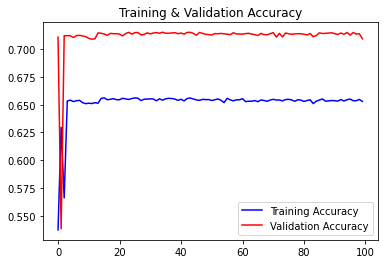

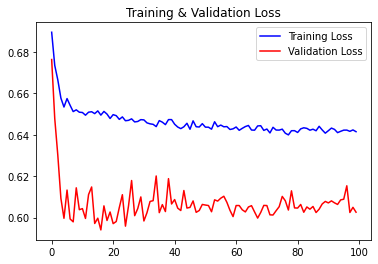

In [ ]:
#plot training and validation accuracy loss to see if 
#there was overfitting, if number of epochs should be changed

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [ ]:
def check_image_output(folder_path, model = model):
  '''
  Function takes random image from a folder path with images as input.
  Than pass it through a model. The output of a function is autoencoded/"predicted" image.
  '''
  #folder content
  folder_cont = os.listdir(folder_path)
  #read original image
  img = cv2.imread(folder_path + '/' + folder_cont[np.random.randint(len(folder_cont))])

  #prepare image to pass through model
  #resize the original image to dimentions of the training dataset
  resized = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_AREA)
  #create new image by passing through a model
  pred = model.predict(np.array([resized]))
  #matplotlib takes range of [0..1] for floats and [0..255] for integers

  #image plot to compare results
  plt.figure(figsize=(12, 12))  
  ax = plt.subplot(2, 1, 1)
  plt.axis("off")
  plt.imshow(resized)
 
  ax = plt.subplot(2, 1, 2)
  plt.imshow(pred[0])
  plt.axis("off")
  plt.savefig(f'img_{model}.jpg')


1/1 [==============================] - 0s 21ms/step


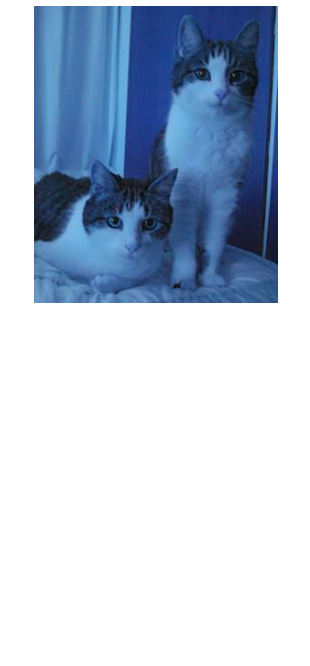

In [ ]:
check_image_output('/content/drive/MyDrive/test/cat/test/cat')

In [ ]:
#the result is not really satisfying
#print out the array interpretation of an image
pred

array([[[[254.99991, 254.99997, 254.99951],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        [[254.99997, 255.     , 254.99997],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        ...,

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,


##Model 1 - Conclusions
The outputed result is not great at all. That is clear, that model wasn't trained enough time (epochs). Also there are probably too few filters applied, so it better to increase the number of neurons and convolutional layers.
Let's discover outputs in model nr. 2 where comments applied.

##Model 2

In [ ]:
model_2 = Sequential()
#Encoder
model_2.add(layers.Conv2D(128, (15, 15),
                        activation='relu',
                        input_shape=(img_width, img_height, 3),
                        padding='same'))
model_2.add(layers.Conv2D(64, (15, 15), activation='relu', padding='same'))
model_2.add(layers.MaxPooling2D((2, 2), padding='same'))
model_2.add(layers.Conv2D(32, (9, 9), activation='relu', padding='same'))
model_2.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same'))
model_2.add(layers.MaxPooling2D((2, 2), padding='same'))
#model_2.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
#model_2.add(layers.MaxPooling2D((2, 2), padding='same'))

#Decoder
#model_2.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
#model_2.add(layers.UpSampling2D((2, 2)))
model_2.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model_2.add(layers.Conv2D(64, (9, 9), activation='relu', padding='same'))
model_2.add(layers.UpSampling2D((2, 2)))
model_2.add(layers.Conv2D(64, (9, 9), activation='relu', padding='same'))
model_2.add(layers.Conv2D(32, (15, 15), activation='relu', padding='same'))
model_2.add(layers.UpSampling2D((2, 2)))
model_2.add(layers.Conv2D(3, (9, 9), activation='sigmoid', padding='same'))


model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 128, 128, 128)     86528     
                                                                 
 conv2d_30 (Conv2D)          (None, 128, 128, 64)      1843264   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        165920    
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        50208     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

In [ ]:
history_2 = model_2.fit(
    normalized_ds, 
    validation_data = normalized_val_ds,
    epochs = 100,
    verbose = 1,
    batch_size = 64
)


Epoch 1/100
16/16 [==============================] - 186s 7s/step - loss: 0.7311 - acc: 0.5014 - val_loss: 0.6835 - val_acc: 0.7152
Epoch 2/100
16/16 [==============================] - 14s 805ms/step - loss: 0.6809 - acc: 0.5467 - val_loss: 0.6779 - val_acc: 0.7150
Epoch 3/100
16/16 [==============================] - 14s 838ms/step - loss: 0.6800 - acc: 0.6551 - val_loss: 0.6753 - val_acc: 0.7082
Epoch 4/100
16/16 [==============================] - 14s 824ms/step - loss: 0.6958 - acc: 0.6477 - val_loss: 0.6804 - val_acc: 0.7126
Epoch 5/100
16/16 [==============================] - 14s 808ms/step - loss: 0.6844 - acc: 0.6126 - val_loss: 0.6800 - val_acc: 0.7152
Epoch 6/100
16/16 [==============================] - 14s 812ms/step - loss: 0.6803 - acc: 0.6552 - val_loss: 0.6772 - val_acc: 0.7147
Epoch 7/100
16/16 [==============================] - 14s 815ms/step - loss: 0.6799 - acc: 0.6552 - val_loss: 0.6771 - val_acc: 0.7152
Epoch 8/100
16/16 [==============================] - 14s 802ms/s

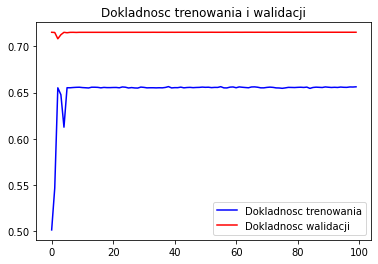

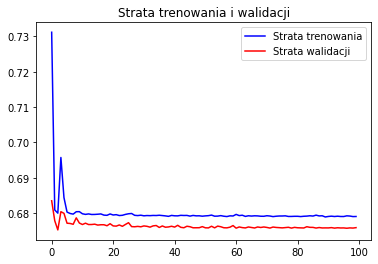

In [ ]:
#Loss and accuracy plot

acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'r', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Strata trenowania')
plt.plot(epochs, val_loss, 'r', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

1/1 [==============================] - 1s 686ms/step


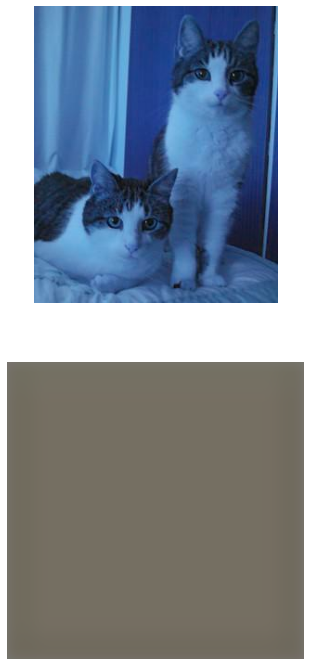

In [ ]:
check_image_output('/content/drive/MyDrive/test/cat/test/cat', model_2)

#Model 3

In [ ]:
model_3 = Sequential()
#Encoder

model_3.add(layers.Conv2D(128, (15, 15),
                        activation='relu',
                        input_shape=(img_width, img_height, 3),
                        padding='same'))
model_3.add(layers.Conv2D(64, (15, 15), activation='relu', padding='same'))
model_3.add(layers.Conv2D(64, (15, 15), activation='relu', padding='same'))
model_3.add(layers.MaxPooling2D((2, 2), padding='same'))
model_3.add(layers.Conv2D(32, (9, 9), activation='relu', padding='same'))
model_3.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same'))
model_3.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
#model_3.add(layers.MaxPooling2D((2, 2), padding='same'))
#model_3.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model_3.add(layers.MaxPooling2D((2, 2), padding='same'))

#Decoder
#model_3.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
#model_3.add(layers.UpSampling2D((2, 2)))
model_3.add(layers.Conv2D(256, (7, 7), activation='relu', padding='same'))
model_3.add(layers.Conv2D(128, (9, 9), activation='relu', padding='same'))
model_3.add(layers.UpSampling2D((2, 2)))
model_3.add(layers.Conv2D(64, (9, 9), activation='relu', padding='same'))
model_3.add(layers.Conv2D(64, (9, 9), activation='relu', padding='same'))
model_3.add(layers.Conv2D(32, (9, 9), activation='relu', padding='same'))
model_3.add(layers.UpSampling2D((2, 2)))
model_3.add(layers.Conv2D(32, (9, 9), activation='relu', padding='same'))
model_3.add(layers.Conv2D(3, (9, 9), activation='sigmoid', padding='same'))


model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 232, 232, 128)     86528     
                                                                 
 conv2d_1 (Conv2D)           (None, 232, 232, 64)      1843264   
                                                                 
 conv2d_2 (Conv2D)           (None, 232, 232, 64)      921664    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 116, 116, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 32)      165920    
                                                                 
 conv2d_4 (Conv2D)           (None, 116, 116, 32)      50208     
                                                      

In [ ]:
history_3 = model_3.fit(
    normalized_ds, 
    validation_data = normalized_val_ds,
    epochs = 100,
    verbose = 1,
    batch_size = 64
)

Epoch 1/100
16/16 [==============================] - 906s 31s/step - loss: 0.8515 - acc: 0.4903 - val_loss: 0.7161 - val_acc: 0.7151
Epoch 2/100
16/16 [==============================] - 79s 5s/step - loss: 0.7323 - acc: 0.3837 - val_loss: 0.6739 - val_acc: 0.4990
Epoch 3/100
16/16 [==============================] - 78s 5s/step - loss: 0.7386 - acc: 0.2061 - val_loss: 0.6886 - val_acc: 0.1675
Epoch 4/100
16/16 [==============================] - 77s 5s/step - loss: 0.6870 - acc: 0.6196 - val_loss: 0.6807 - val_acc: 0.7132
Epoch 5/100
16/16 [==============================] - 77s 5s/step - loss: 0.6804 - acc: 0.6591 - val_loss: 0.6772 - val_acc: 0.7153
Epoch 6/100
16/16 [==============================] - 75s 5s/step - loss: 0.6796 - acc: 0.6592 - val_loss: 0.6761 - val_acc: 0.7153
Epoch 7/100
16/16 [==============================] - 77s 5s/step - loss: 0.6790 - acc: 0.6592 - val_loss: 0.6759 - val_acc: 0.7153
Epoch 8/100
16/16 [==============================] - 77s 5s/step - loss: 0.6789 -

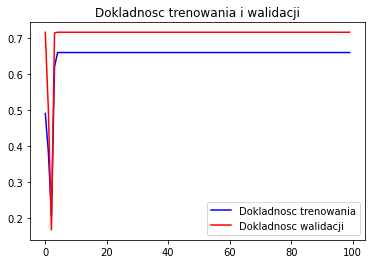

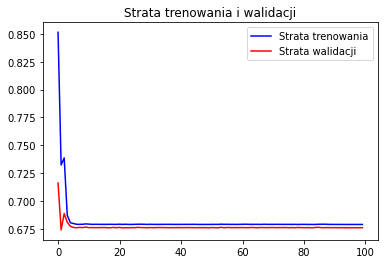

In [ ]:
#Loss and accuracy plot

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'r', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Strata trenowania')
plt.plot(epochs, val_loss, 'r', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

1/1 [==============================] - 0s 29ms/step


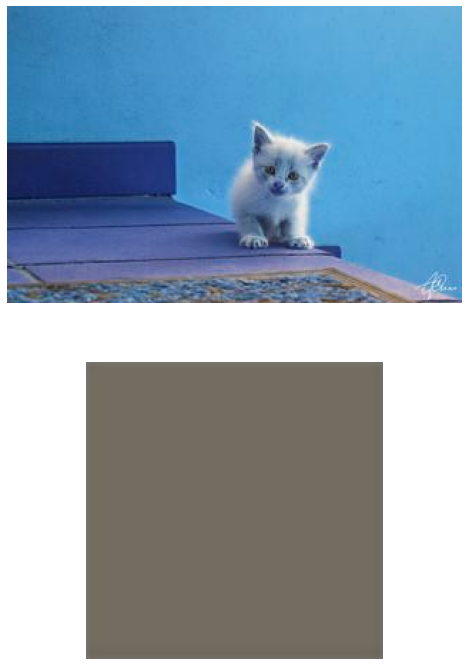

In [ ]:
check_image_output('/content/drive/MyDrive/test/cat/test/cat', model_3)

##Saving model

In [ ]:
import pickle

model_name = 'Autoencoder_model_NoRotation.pkl'

pickle.dump(model_3, open(model_name, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......up_sampling2d
.........vars
......up_sampling2d_1
.........vars
...metrics
......mean
.........vars
......

#Autoencoder summarize
Although results in mine shown models aren't really fancy there is a big room to improve the model. Model could be tuned much more and traind for a longer time (more epochs) thats crutial for this kind of network!. The training data set might be extended and play with some parameters such as batch size, entry image size, quantity of filters etc. However this need time for training and exceed standard plan of Golab and my personal machine capabilities. Better results could be achieved for grayscale images, bacause of the tensor size.

Comparing model 1 with model 3 it is clearly visible improvment, at least change of color and some basic edges recognition. Still does not remind a cat, however we can see that higher amount of filters in model may cause this change.
Some tuning with number of epochs, size of batches and other hyperparameters with a bit of patience and time may make a difference. 

Definitely will come back to this project later on with some more computational capacities. 

#Some errors I had on my way to create an autoencoder model

Tutaj miałem Taki błąd

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 891, in train_step
        self._validate_target_and_loss(y, loss)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 848, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=binary_crossentropy, and therefore expects target data to be provided in `fit()`.

I jeszcze taki (po drugim uruchomieniu):



---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-61-e08901c993b1> in <module>
----> 1 history = model.fit(
      2     train_ds,
      3     validation_data = val_ds,
      4     epochs = 40,
      5     verbose = 1,

1 frames
/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py in _call(self, *args, **kwds)
    945       # In this case we have created variables on the first call, so we run the
    946       # defunned version which is guaranteed to never create variables.
--> 947       return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
    948     elif self._stateful_fn is not None:
    949       # Release the lock early so that multiple threads can perform the call

TypeError: 'NoneType' object is not callable


